Fazendo _download_ do _dataset_:

In [2]:
import os
if not os.path.isfile('btc.csv'):
  !wget https://raw.githubusercontent.com/brynmwangy/predicting-bitcoin-prices-using-LSTM/master/btc.csv ;

Importando as bibliotecas e _frameworks_ necessários:

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


Lendo o _dataset_ e armazenando somente o atributo que deve-se prever, que é a coluna "Close".

In [36]:
df = pd.read_csv('btc.csv')
df = df.loc[::-1].set_index(df.index)
date = df['Date']
df_close = df.Close.values
print(df_close)
print(df_close.shape)

[ 370.    378.    378.   ... 7584.15 7459.11 7520.  ]
(1273,)


Pré-processando os dados para que os valores dos dados fiquem entre 0 e 1:

In [15]:
mms = MinMaxScaler()
data = mms.fit_transform(df_close.reshape(-1,1))

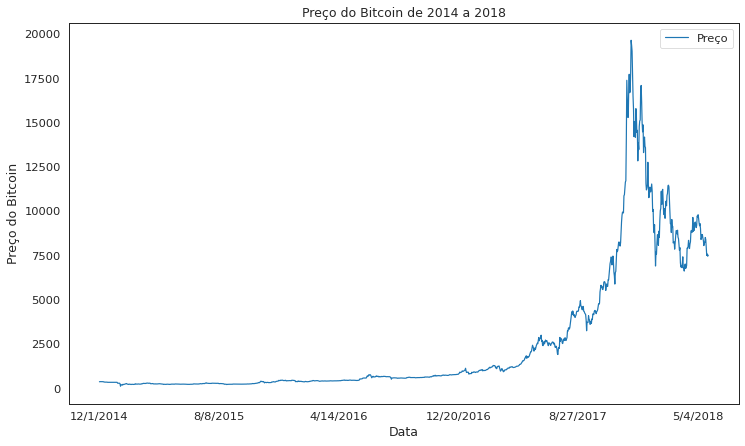

In [37]:
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Preço do Bitcoin de 2014 a 2018')
plt.xticks(np.arange(0,len(data),250))
plt.xlabel('Data')
plt.ylabel('Preço do Bitcoin')
plt.plot(df.loc[:, 'Date'], mms.inverse_transform(data.reshape(-1,1)), label='Preço')
plt.legend()
plt.show()

In [23]:
def window_data(data, window_size):
    x = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        x.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(x) ==  len(y)
    return x, y

Separando o _dataset_ em treino e teste:

In [47]:
x, y = window_data(data, 10)
"""x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, train_size=0.875, shuffle=False)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_validate = np.array(x_validate)
y_validate = np.array(y_validate)
x_test = np.array(x_test)
y_test = np.array(y_test)"""
x_train = np.array(x[:891])
y_train = np.array(y[:891])
x_validate = np.array(x[891:1145])
y_validate = np.array(y[891:1145])
x_test = np.array(x[1145:])
y_test = np.array(y[1145:])

In [48]:
print("X_train size: {}".format(x_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_valid size: {}".format(x_validate.shape))
print("y_valid size: {}".format(y_validate.shape))
print("X_test size: {}".format(x_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (891, 10, 1)
y_train size: (891, 1)
X_valid size: (254, 10, 1)
y_valid size: (254, 1)
X_test size: (118, 10, 1)
y_test size: (118, 1)


Treinando o modelo base de LSTM:

Epoch 1/100
128/128 - 3s - loss: 1.6839e-04 - mse: 1.6839e-04 - val_loss: 0.0115 - val_mse: 0.0115 - 3s/epoch - 20ms/step
Epoch 2/100
128/128 - 1s - loss: 2.0283e-05 - mse: 2.0283e-05 - val_loss: 0.0064 - val_mse: 0.0064 - 612ms/epoch - 5ms/step
Epoch 3/100
128/128 - 1s - loss: 1.4964e-05 - mse: 1.4964e-05 - val_loss: 0.0052 - val_mse: 0.0052 - 643ms/epoch - 5ms/step
Epoch 4/100
128/128 - 1s - loss: 1.4982e-05 - mse: 1.4982e-05 - val_loss: 0.0046 - val_mse: 0.0046 - 612ms/epoch - 5ms/step
Epoch 5/100
128/128 - 1s - loss: 1.2696e-05 - mse: 1.2696e-05 - val_loss: 0.0046 - val_mse: 0.0046 - 607ms/epoch - 5ms/step
Epoch 6/100
128/128 - 1s - loss: 1.0007e-05 - mse: 1.0007e-05 - val_loss: 0.0056 - val_mse: 0.0056 - 618ms/epoch - 5ms/step
Epoch 7/100
128/128 - 1s - loss: 1.6571e-05 - mse: 1.6571e-05 - val_loss: 0.0049 - val_mse: 0.0049 - 618ms/epoch - 5ms/step
Epoch 8/100
128/128 - 1s - loss: 1.4120e-05 - mse: 1.4120e-05 - val_loss: 0.0046 - val_mse: 0.0046 - 619ms/epoch - 5ms/step
Epoch 9/10

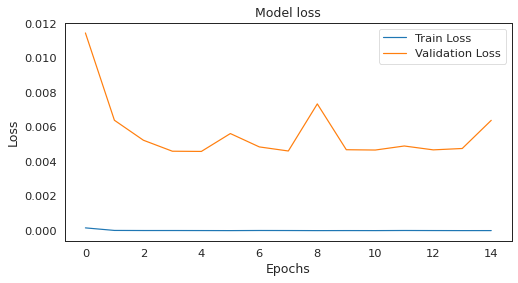

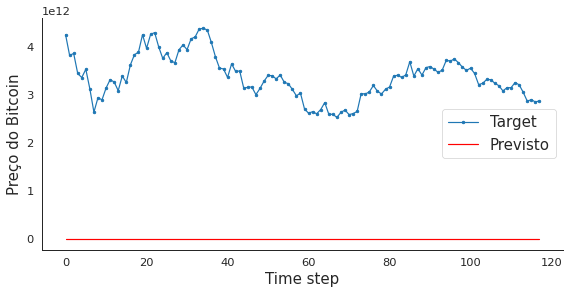

In [53]:
model1 = keras.Sequential()
model1.add(layers.LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(units=1))
model1.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.01),metrics=['mse'])
history1 = model1.fit(x_train, y_train, validation_data=(x_validate, y_validate), epochs=100, batch_size=7, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], verbose=2)
y_pred = model1.predict(x_test)

plt.figure(figsize=(8,4))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();

test_predict = mms.inverse_transform(y_pred[:,0])
y_test = mms.inverse_transform(y_test)
aa=[x for x in range(len(y_test))]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test, marker='.', label="Target")
plt.plot(aa, test_predict[:,0], 'r', label="Previsto")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Preço do Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

Epoch 1/100
90/90 - 3s - loss: 1.2831e-04 - val_loss: 0.0268 - 3s/epoch - 30ms/step
Epoch 2/100
90/90 - 0s - loss: 4.9398e-05 - val_loss: 0.0197 - 445ms/epoch - 5ms/step
Epoch 3/100
90/90 - 0s - loss: 3.4995e-05 - val_loss: 0.0147 - 439ms/epoch - 5ms/step
Epoch 4/100
90/90 - 0s - loss: 2.7846e-05 - val_loss: 0.0123 - 452ms/epoch - 5ms/step
Epoch 5/100
90/90 - 0s - loss: 2.4219e-05 - val_loss: 0.0105 - 446ms/epoch - 5ms/step
Epoch 6/100
90/90 - 0s - loss: 1.9476e-05 - val_loss: 0.0092 - 451ms/epoch - 5ms/step
Epoch 7/100
90/90 - 0s - loss: 1.8801e-05 - val_loss: 0.0083 - 432ms/epoch - 5ms/step
Epoch 8/100
90/90 - 0s - loss: 1.6459e-05 - val_loss: 0.0073 - 430ms/epoch - 5ms/step
Epoch 9/100
90/90 - 0s - loss: 1.4811e-05 - val_loss: 0.0068 - 445ms/epoch - 5ms/step
Epoch 10/100
90/90 - 0s - loss: 1.2996e-05 - val_loss: 0.0065 - 431ms/epoch - 5ms/step
Epoch 11/100
90/90 - 0s - loss: 1.1283e-05 - val_loss: 0.0058 - 438ms/epoch - 5ms/step
Epoch 12/100
90/90 - 0s - loss: 1.1098e-05 - val_loss:

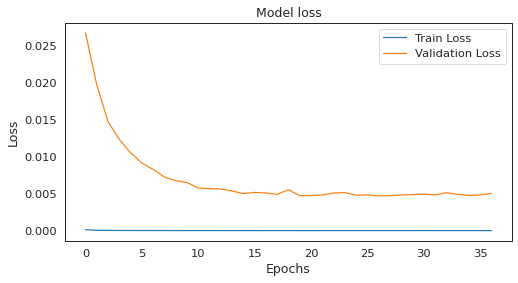

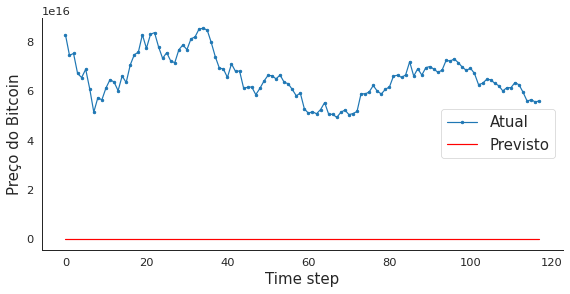

In [54]:
model2 = keras.Sequential()
model2.add(layers.LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(units=1))
model2.compile(loss='mean_squared_error', optimizer='adam')
history2 = model2.fit(x_train, y_train, validation_data=(x_validate, y_validate), epochs=100, batch_size=10, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], verbose=2)
y_pred = model2.predict(x_test)

plt.figure(figsize=(8,4))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();

test_predict = mms.inverse_transform(y_pred[:,0])
y_test = mms.inverse_transform(y_test)
aa=[x for x in range(len(y_test))]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test, marker='.', label="Atual")
plt.plot(aa, test_predict[:,0], 'r', label="Previsto")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Preço do Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();